In [13]:
%pylab inline
import pandas as pd
from jupyterthemes import jtplot

jtplot.style(theme='grade3')

Populating the interactive namespace from numpy and matplotlib


In [14]:
layer_scores = pd.read_csv('output/2019-layer-scores.csv')

# Normalize columns
First, let's normalize all of the statistics in the dataset.

We want to make the range of all variables 0-100. It'll make it easier to do a radar plot.

First, we'll look at the distribution of one metric.

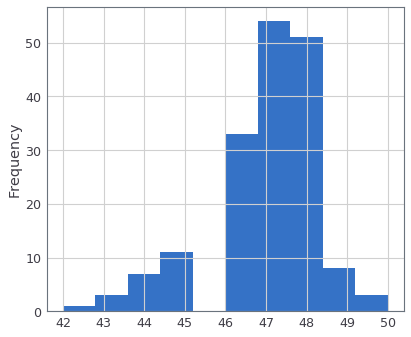

In [15]:
layer_scores['layer4-alexa-rankings'].plot.hist()

When we normalize it, we should see the same distribution.

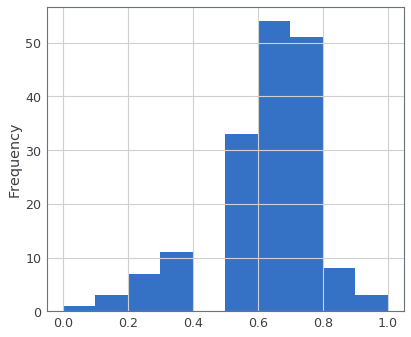

In [16]:
def normalize (df: pd.DataFrame) -> pd.DataFrame:
    '''Convert to values 0 to 1.'''
    return (df - df.min()) / (df.max() - df.min())


normalize(layer_scores['layer4-alexa-rankings']).plot.hist()

One more issue here is that network interference events are power-law distributed.

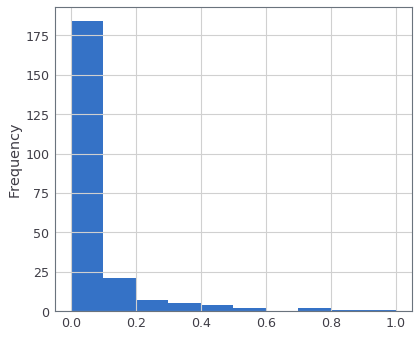

In [17]:
normalize(layer_scores['layer3-network-interference-rate']).plot.hist()

That means that most countries won't be very much fun to look at! We can fix this by taking the log.

We have the same problem with data laws

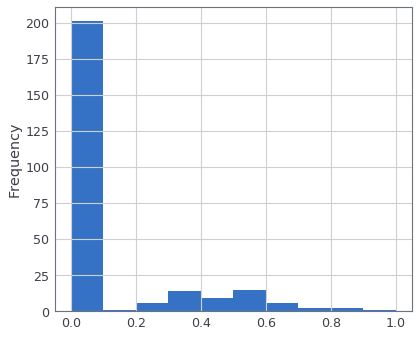

In [18]:
normalize(layer_scores['layer5-discrete-categories-data-laws']).plot.hist()

# Simplify dataset

That looks right. Let's perform this mapping for all of our metrics to produce a simplified dataset.

In [57]:
data = pd.DataFrame({
    'Country': layer_scores['Country'],
    'Alpha-2 code': layer_scores['Alpha-2 code'],
    'layer2 (ipv6)': normalize(layer_scores['layer2-ipv6-adoption']),
    'layer3 (network interference)': normalize(layer_scores['layer3-network-interference-rate']).fillna(value=0),
#     'layer3 (network interference)': normalize(layer_scores['layer3-network-interference-rate']).fillna(value=0),
    'layer4 (popular website locality)':  normalize(layer_scores['layer4-alexa-rankings']),
    'layer5 (data laws)': normalize(layer_scores['layer5-discrete-categories-data-laws']),
})
data.head()

,Country,Alpha-2 code,layer2 (ipv6),layer3 (network interference),layer4 (popular website locality),layer5 (data laws)
0,Afghanistan,AF,0.001111,0.053566,0.625,0.0
1,Albania,AL,0.000000,0.007385,0.500,0.0
2,Algeria,DZ,0.000000,0.011133,0.750,0.0
3,American Samoa,AS,0.000000,0.000000,NaN,0.0
4,Andorra,AD,0.000000,0.000000,NaN,0.0


# Produce radar plots

Now we'll want to produce radar plots for each country (or for sets of countries).

In [20]:
def find_country (alpha2: str) -> pd.DataFrame:
    return data[data['Alpha-2 code']==alpha2]

find_country('CN')

,Country,Alpha-2 code,layer2 (ipv6),layer3 (network interference),layer4 (popular website locality),layer5 (data laws)
45,China,CN,0.025366,0.446349,1.0,1.0


In [52]:
# number of variable
def radar_plot (df, filename=None):
    
    non_numeric_cols = ['Country','Alpha-2 code']
    
    categories=list(df.drop(columns=non_numeric_cols))
    N = len(categories)
     
#     # We are going to plot the first line of the data frame.
#     # But we need to repeat the first value to close the circular graph:
# #     values=df.loc[0].drop(columns=['Country','Alpha-2 code']).values.flatten().tolist()
#     values= df.values.flatten().tolist()
#     values += values[:1]
# #     values
     
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
     
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
     
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)
     
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
    plt.ylim(0,1)
     
#     # Plot data
#     ax.plot(angles, values, linewidth=1, linestyle='solid')
     
#     # Fill area
#     ax.fill(angles, values, 'b', alpha=0.1)
    for i in range(len(df)):
        values=df.iloc[i].drop(non_numeric_cols).values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=df.iloc[i]['Country'])
        ax.fill(angles, values, 'b', alpha=0.05)
    
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    if filename:
        plt.savefig(filename, 
                    dpi=300,
                    bbox_inches='tight')

    
    
# radar_plot(
#     find_country('DK')\
#         .append(find_country('SE'))\
#         .append(find_country('NO'))
# )

# Findings

Making observations about 'profiles' groups of countries.

###  The Scandinavains
Let's start with the Scandinavians (Denmark, Norway and Sweden). These countries
are very similar to one another in a variety of ways. Norway stands out as being
outside the EU, and exceptionally wealthy. However, the three share culture,
basic systems of governance, and arguably a single language. [fn:4]

Immediately, Norway stands out as having higher IPv6 adoption, and no laws about
cross-border data flow. Denmark also has much less "fragmentation" (locality) at
the content layer than Sweden.

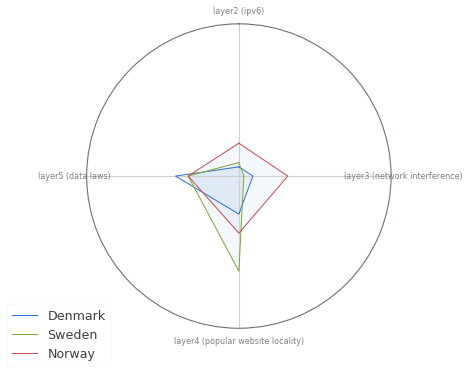

In [55]:
radar_plot(
    find_country('DK')\
        .append(find_country('SE'))\
        .append(find_country('NO'))
    , filename="writing/figures/scandinavians.png"
)

Immediately, Norway stands out as having higher IPv6 adoption, and no laws about
cross-border data flow. Denmark also has much less "fragmentation" (locality) at
the content layer than Sweden.


## Five eyes


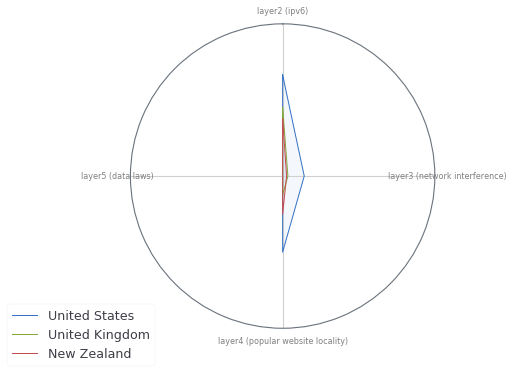

In [47]:
radar_plot(
    find_country('US')\
        .append(find_country('GB'))\
#         .append(find_country('CA'))\
#         .append(find_country('AU'))\
        .append(find_country('NZ'))\
)

Let's start by looking at United States, United Kingdom, and New Zealand. The UK
and New Zealand are similar, but the United States has very little network
interference, and more fragmentation on layers 2 and 3.

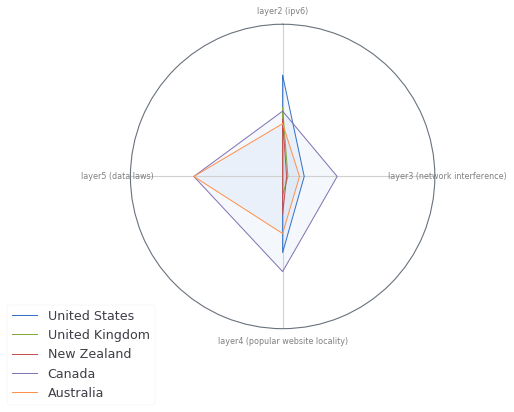

In [54]:
radar_plot(
    find_country('US')\
        .append(find_country('GB'))\
        .append(find_country('NZ'))\
        .append(find_country('CA'))\
        .append(find_country('AU'))\
    , filename="writing/figures/five-eyes-individual.png"
)

Now let's add in Canada and Australia. These two countries have laws about
cross-border data flow, and Australia's network interference is near zero.

Other than that, these countries are all similar to one another, except for the
United States. The United States has lower transport-layer fragmentation and
higher network- and content-layer than the rest of the pack.

Regardless, let's look at an "average" of the 5-eyes countries.

In [25]:
def create_block (
    block_name: str, 
    alpha2s: list,
) -> pd.DataFrame:
    '''Produces a mean of all countries in a block.'''
    block = find_country(alpha2s[0])
    for alpha2 in alpha2s[1:]:
#         print(find_country(alpha2))
        block = block.append(find_country(alpha2))
    block = block.mean().to_frame().T
    block['Alpha-2 code'] = ''
    block['Country'] = block_name
    return block

#     five_eyes=\
five_eyes = create_block('Five eyes', [
    'US', 'GB', 'NZ', 'CA', 'AU'
])
five_eyes


,layer2 (ipv6),layer3 (network interference),layer4 (popular website locality),layer5 (data laws),Alpha-2 code,Country
0,0.453101,0.134412,0.375,0.233333,,Five eyes


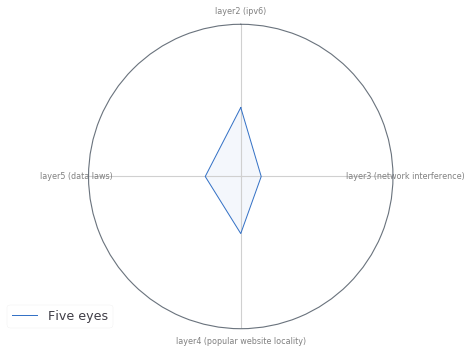

In [26]:
radar_plot(five_eyes)

How do five-eyes compare with the G7?

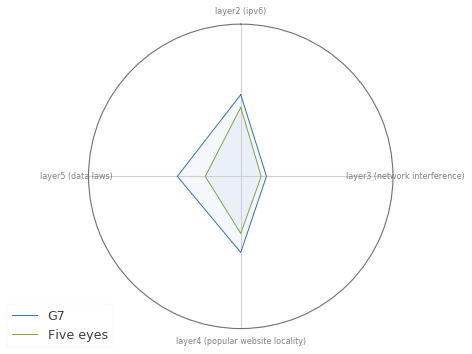

In [27]:
g7 = create_block('G7', [
    'CA', 'FR', 'DE', 'IT', 'JP', 'US', 'GB'
])
radar_plot(g7.append(five_eyes))

G7 and five eyes countries are roughly similar, those G7 has higher fragmentation across the board.


# China, belt-and-road

That was all warmup. Let's look at China.

/home/ffff/.local/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


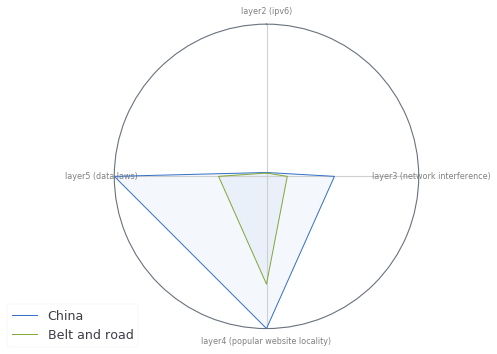

In [87]:
radar_plot(
    find_country('CN')\
        .append(belt_and_road)
    , filename='writing/figures/china-vs-belt-and-road.png'
)

I'm showing China here with Five Eyes, for comparison.

We can see a qualitatively different profile here. There's more network interference,
but the real stand-out is content-layer fragmentation. This fragmentation is
extremely high, probably the result of both censorship and language/culture.

As a sanity check, how does China compare with its East Asian neighbors?


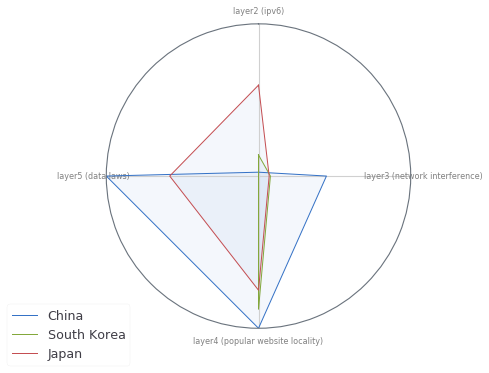

In [29]:
radar_plot(
    find_country('CN')\
        .append(find_country('KR').iloc[1])\
        .append(find_country('JP'))\
)

Overall, it's US-allied neighbors have slightly lower content layer
fragmentation, and higher IPv6 uptake.

Now, what happens when we average China with all of the belt-and-road countries?

*Note*: there is no authoritative list of the belt-and-road countries, as many Western and South American countries have signed various belt-and-road-related treaties. I'm including a highly (let's call it) "intuitive" list of developing Asian and African countries who have developed diplomatic relationships with China and/or accepted loans for large infrastructure projects, without major outcry (i.e., excluding Malaysia).

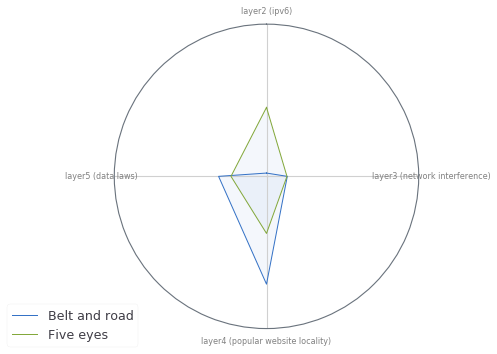

In [56]:
belt_and_road = create_block('Belt and road', [
    # asia
    'CN', # china
    'LA', # laos
    'ID', # indonesia
    'MN', # mongolia
    # beyond asia
    'PK', # pakistan
    'DJ', # djbouti
    'AR', # argentina
    'SD', # sudan
    'JM', # jamaica
])

radar_plot(belt_and_road.append(five_eyes), filename='writing/figures/belt-and-road-vs-fiveeyes.png')

# Other "high-touch" countries

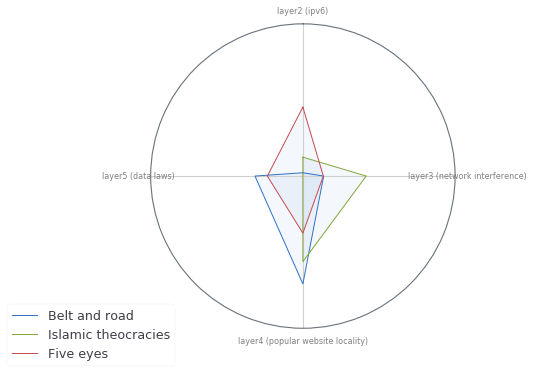

In [58]:
islamic_theocracies = create_block('Islamic theocracies', [
    'SA', # saudi arabia
    'AE', # UAE
    'KW', # kuwait
    'BH', # bahrain
    'IR', # iran
])

radar_plot(
    belt_and_road\
        .append(islamic_theocracies)\
        .append(five_eyes)\
    , filename='writing/figures/three-bloc.png'
)

# 'Best buddies'

## Europe - similar and diffferent

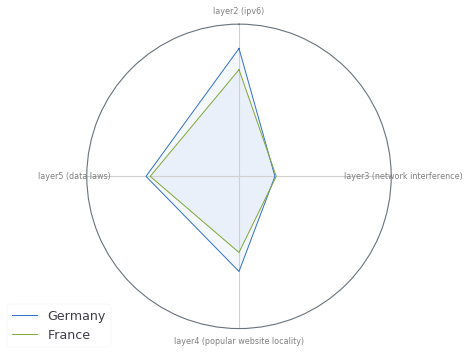

In [69]:
radar_plot(
    find_country('DE')\
        .append(find_country('FR'))\
)

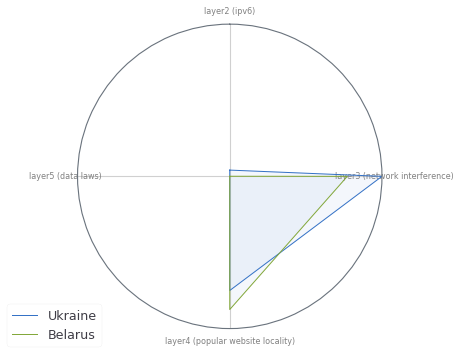

In [83]:
radar_plot(
    find_country('UA')\
        .append(find_country('BY'))\
)

In [68]:
layer_scores.sort_values(by='layer3-network-interference-rate', ascending=False)

,Unnamed: 0,Country,Alpha-2 code,Alpha-3 code,Numeric code,layer4-alexa-rankings,layer5-discrete-categories-data-laws,layer2-ipv6-adoption,layer3-network-interference-rate
238,238,Ukraine,UA,UKR,804,48.0,0.0,2.22,0.714586
105,105,"Iran, Islamic Republic of",IR,IRN,364,NaN,0.0,0.17,0.620126
19,19,Belarus,BY,BLR,112,49.0,0.0,0.03,0.551983
185,185,Réunion,RE,REU,638,NaN,0.0,25.06,0.517155
200,200,Saudi Arabia,SA,SAU,682,48.0,0.0,15.69,0.362870
70,70,Estonia,EE,EST,233,48.0,11.0,25.90,0.359059
239,239,United Arab Emirates,AE,ARE,784,48.0,0.0,17.67,0.340206
160,160,Netherlands,NL,NLD,528,46.0,12.0,19.61,0.336156
45,45,China,CN,CHN,156,50.0,36.0,1.37,0.318955
103,103,India,IN,IND,356,46.0,32.0,40.57,0.290802


/home/ffff/.local/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


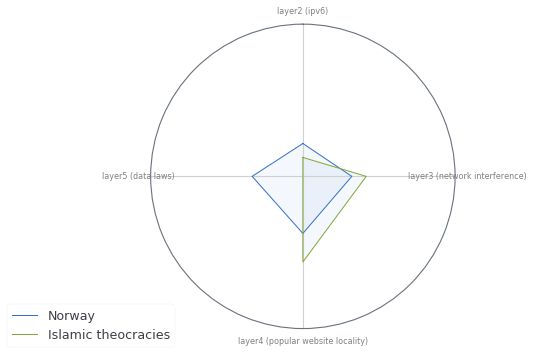

In [99]:
radar_plot(
    find_country('NO')\
        .append(islamic_theocracies)\
    , filename='writing/figures/no-vs-islamic.png'
)

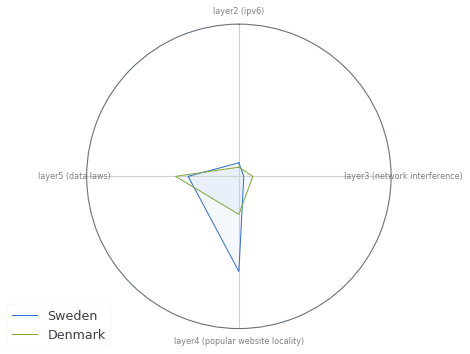

In [33]:
radar_plot(
    find_country('SE')\
        .append(find_country('DK'))\
)

## South and Southeast Asia

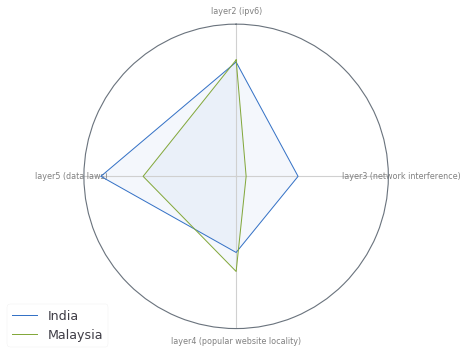

In [34]:
radar_plot(
    find_country('IN')\
        .append(find_country('MY'))\
)

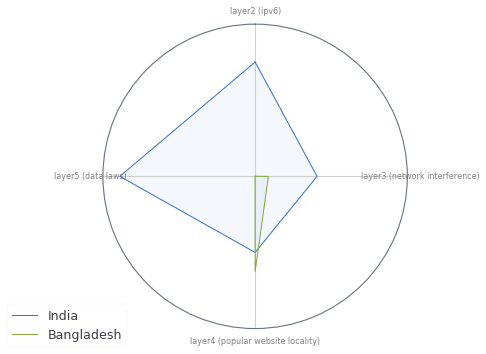

In [89]:
radar_plot(
    find_country('IN')\
        .append(find_country('BD'))\
    , filename='writing/figures/in-bd.png'
)

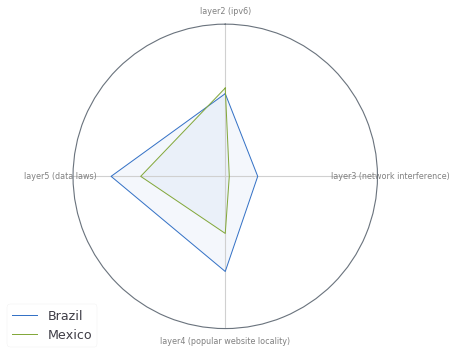

In [36]:
radar_plot(
    find_country('BR')\
        .append(find_country('MX'))\
)


In [37]:
find_country('BD')

,Country,Alpha-2 code,layer2 (ipv6),layer3 (network interference),layer4 (popular website locality),layer5 (data laws)
17,Bangladesh,BD,0.000741,0.086984,0.625,0.0


## South America

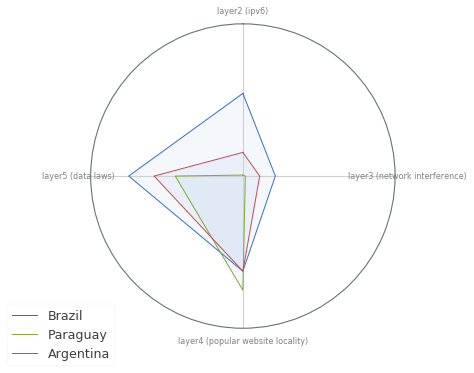

In [38]:
radar_plot(
    find_country('BR')\
        .append(find_country('PY'))\
        .append(find_country('AR'))\
)


## Caribbean

/home/ffff/.local/lib/python3.6/site-packages/matplotlib/projections/polar.py:63: RuntimeWarning: invalid value encountered in less
  mask = r < 0


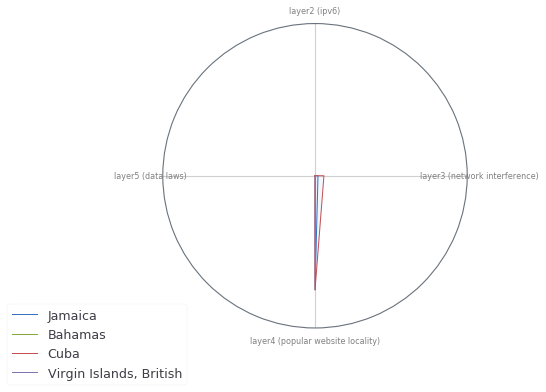

In [90]:
radar_plot(
    find_country('JM')\
        .append(find_country('BS'))\
        .append(find_country('CU'))\
        .append(find_country('VG'))\
)

# A more complex picture

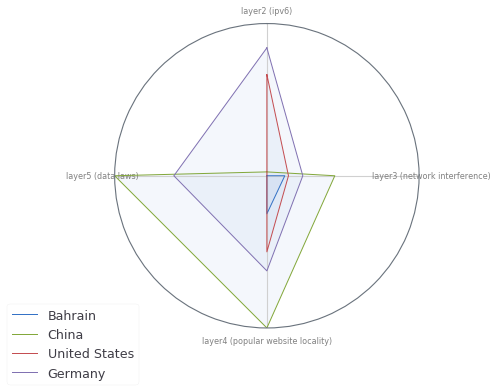

In [53]:
radar_plot(
    find_country('BH')\
        .append(find_country('CN'))\
        .append(find_country('US'))\
#         .append(find_country('DK'))\
        .append(find_country('DE'))\
    , filename='writing/figures/us-cn-bh-de.png'
)

Everyone is differnt in different ways! Not a bi-polar internet at all.